In [1]:
import geopandas as gpd
import geojson
import pandas as pd
import glob
import operator
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

In [4]:
start_date = '2013-12-01'
end_date = '2013-12-22'

column_names = ['cellId', 'Time Interval', 'Country code', 'SMS-in activity', 'SMS-out activity', 'Call-in activity', 'Call-out activity', 'Internet traffic activity']

files = glob.glob('dataverse_files' + '\sms-call-internet-mi-2013-12*')
i = 0
file_name = []
for file in files:
    if i <= 21:
        file_name.append(file)
        i = i+1
    else: break

df_history = pd.DataFrame({})
for file in file_name:
    df_file = pd.read_csv(file, delimiter='\t', names=column_names) 
    df_history = df_history.append(df_file)
df_history['Time Interval'] = pd.to_datetime(df_history['Time Interval'], unit='ms')

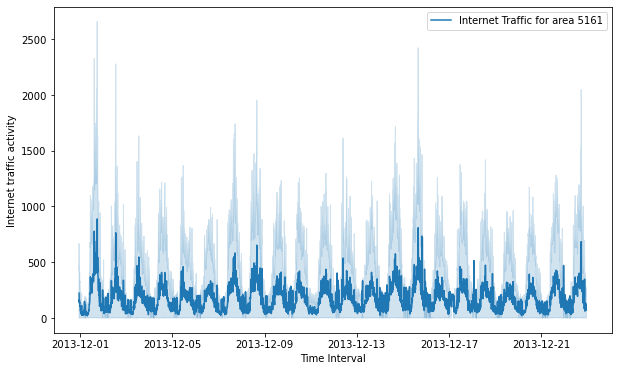

In [5]:
plt.figure(figsize=(10, 6))
df_grouped = df_history.groupby('cellId')
area_5161 = df_grouped.get_group(5161)
sns.lineplot(data=area_5161, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 5161')

plt.legend()

In [6]:
#Test stationarity of the data
from statsmodels.tsa.stattools import adfuller
adf = adfuller(area_5161['Internet traffic activity'].dropna(), autolag='AIC')
adf

(-7.05762275670367,
 5.324514851192397e-10,
 48,
 24948,
 {'1%': -3.430612144178576,
  '5%': -2.8616558597794346,
  '10%': -2.5668316687748196},
 396836.58823488705)

In [7]:
adf_result = pd.Series(adf[0:4], index=['test_stat','p-value','lags','num_observations'])
for key,value in adf[4].items():
    adf_result['Critical Value (%s)'%key] = value
print (adf_result)

test_stat              -7.057623e+00
p-value                 5.324515e-10
lags                    4.800000e+01
num_observations        2.494800e+04
Critical Value (1%)    -3.430612e+00
Critical Value (5%)    -2.861656e+00
Critical Value (10%)   -2.566832e+00
dtype: float64


In [8]:
#The test statistic is smaller than the critical values so we can say that the data is stationnary. We can go ahead and build the model

df_5161 = area_5161[['Time Interval', 'Internet traffic activity']].copy(deep=True)
df_5161['diff1'] = df_5161['Internet traffic activity'].diff()
df_5161['diff24'] = df_5161['Internet traffic activity'].diff(24)

# p = 1, q=1, d=1




<Figure size 720x432 with 0 Axes>

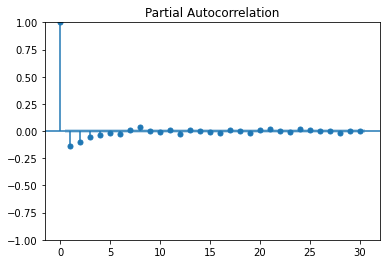

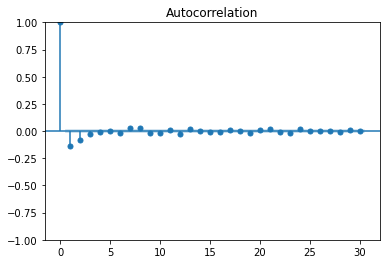

In [9]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10, 6))
plot_pacf(df_5161['diff24'].dropna(), lags=30);
plot_acf(df_5161['diff24'].dropna(), lags=30);

In [16]:
#ARIMA(df_5161['Internet traffic activity'], order = ())
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# df_5161 = df_5161.set_index(['Time Interval'])

t = df_5161[df_5161['Time Interval'] < '2013-12-15 04:00:00']
train_data = t[t['Time Interval'] >= '2013-12-10 04:00:00']
train_data['Internet traffic activity'].fillna(train_data['Internet traffic activity'].mean(), inplace=True)

test_data = df_5161[df_5161['Time Interval'] >= '2013-12-16 04:00:00']
test_data['Internet traffic activity'].fillna(test_data['Internet traffic activity'].mean(), inplace=True)

model = SARIMAX(train_data['Internet traffic activity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
mfit = model.fit()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
#print(len(mfit))
pred_5161 = mfit.predict(start=test_data.index[0], end=test_data.index[100])

C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [18]:
pred_5161

2348772    11561.172138
2348773    11571.366920
2348774    11564.486355
2348775    11565.871815
2348776    11561.191526
               ...     
2348868    11561.637455
2348869    11571.832238
2348870    11564.951673
2348871    11566.337132
2348872    11561.656844
Name: predicted_mean, Length: 101, dtype: float64

<AxesSubplot:xlabel='Time Interval', ylabel='Internet traffic activity'>

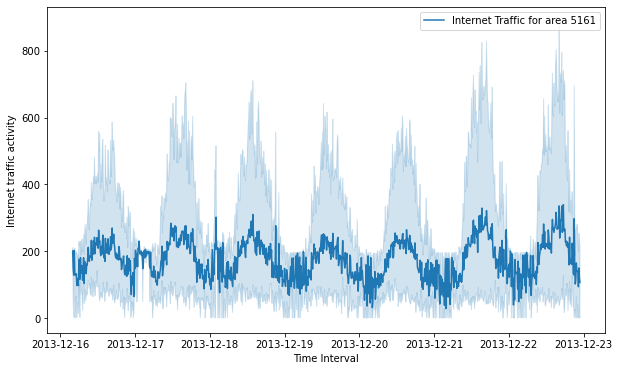

In [19]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=test_data, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 5161')

<AxesSubplot:ylabel='predicted_mean'>

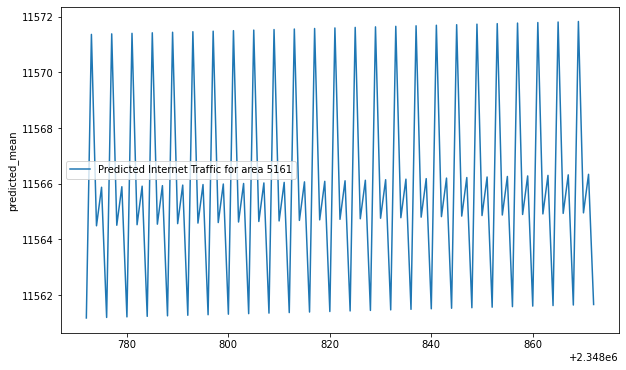

In [42]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_5161, label='Predicted Internet Traffic for area 5161')

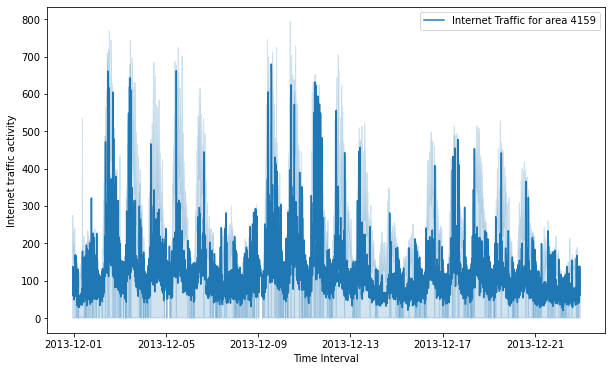

In [21]:
plt.figure(figsize=(10, 6))

area_4159 = df_grouped.get_group(4159)
sns.lineplot(data=area_4159, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 4159')
plt.legend()

In [22]:
#Test stationarity of the data
from statsmodels.tsa.stattools import adfuller
adf = adfuller(area_4159['Internet traffic activity'].dropna(), autolag='AIC')
adf_result = pd.Series(adf[0:4], index=['test_stat','p-value','lags','num_observations'])
for key,value in adf[4].items():
    adf_result['Critical Value (%s)'%key] = value
print (adf_result)

test_stat              -5.986744e+00
p-value                 1.784736e-07
lags                    3.400000e+01
num_observations        8.570000e+03
Critical Value (1%)    -3.431113e+00
Critical Value (5%)    -2.861877e+00
Critical Value (10%)   -2.566950e+00
dtype: float64


In [23]:
df_4159 = area_4159[['Time Interval', 'Internet traffic activity']].copy(deep=True)
df_4159['diff1'] = df_4159['Internet traffic activity'].diff()
df_4159['diff24'] = df_4159['Internet traffic activity'].diff(24)

<Figure size 720x432 with 0 Axes>

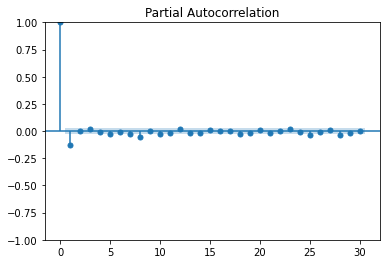

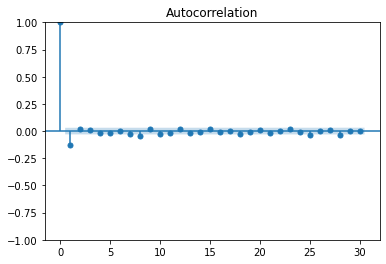

In [24]:
plt.figure(figsize=(10, 6))
plot_pacf(df_4159['diff24'].dropna(), lags=30);
plot_acf(df_4159['diff24'].dropna(), lags=30);

In [25]:
t = df_4159[df_4159['Time Interval'] < '2013-12-15 04:00:00']
train_data = t[t['Time Interval'] >= '2013-12-10 04:00:00']
train_data['Internet traffic activity'].fillna(train_data['Internet traffic activity'].mean(), inplace=True)

test_data = df_4159[df_4159['Time Interval'] >= '2013-12-16 04:00:00']
test_data['Internet traffic activity'].fillna(test_data['Internet traffic activity'].mean(), inplace=True)

model = SARIMAX(train_data['Internet traffic activity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
mfit = model.fit()


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
pred_4159 = mfit.predict(start=test_data.index[0], end=test_data.index[100])

C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
pred_4159

1703143   -19255.008166
1703144   -19254.700592
1703145   -19255.304736
1703146   -19253.952515
1703147   -19255.053705
               ...     
1703239   -19256.101088
1703240   -19255.793514
1703241   -19256.397658
1703242   -19255.045437
1703243   -19256.146627
Name: predicted_mean, Length: 101, dtype: float64

<AxesSubplot:xlabel='Time Interval', ylabel='Internet traffic activity'>

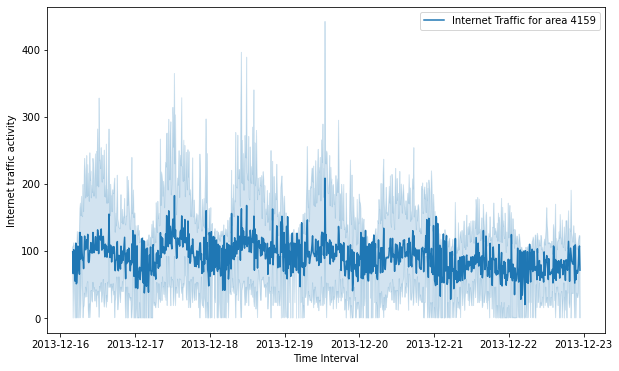

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=test_data, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 4159')

<AxesSubplot:ylabel='predicted_mean'>

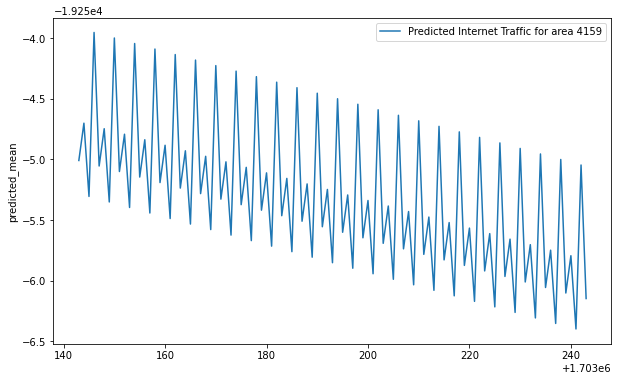

In [41]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_4159, label='Predicted Internet Traffic for area 4159') 

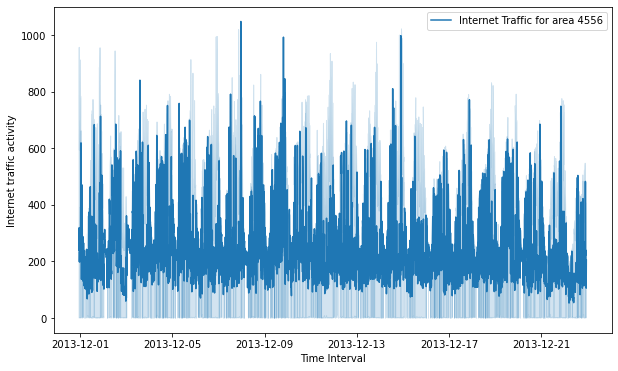

In [30]:
plt.figure(figsize=(10, 6))

area_4556 = df_grouped.get_group(4556)
sns.lineplot(data=area_4556, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 4556')
plt.legend()

In [31]:
#Test stationarity of the data
from statsmodels.tsa.stattools import adfuller
adf = adfuller(area_4556['Internet traffic activity'].dropna(), autolag='AIC')
adf_result = pd.Series(adf[0:4], index=['test_stat','p-value','lags','num_observations'])
for key,value in adf[4].items():
    adf_result['Critical Value (%s)'%key] = value
print (adf_result)

test_stat              -9.756942e+00
p-value                 7.744325e-17
lags                    3.200000e+01
num_observations        7.903000e+03
Critical Value (1%)    -3.431178e+00
Critical Value (5%)    -2.861906e+00
Critical Value (10%)   -2.566965e+00
dtype: float64


In [32]:
df_4556 = area_4556[['Time Interval', 'Internet traffic activity']].copy(deep=True)
df_4556['diff1'] = df_4556['Internet traffic activity'].diff()
df_4556['diff24'] = df_4556['Internet traffic activity'].diff(24)

<Figure size 720x432 with 0 Axes>

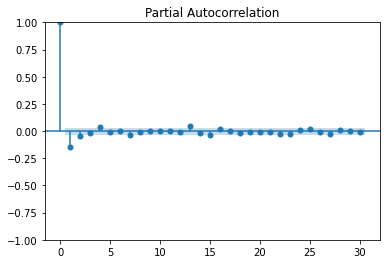

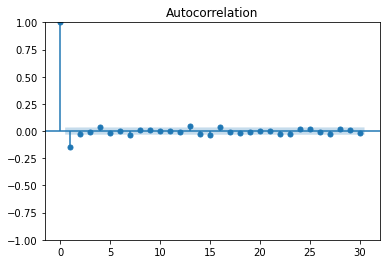

In [33]:
plt.figure(figsize=(10, 6))
plot_pacf(df_4556['diff24'].dropna(), lags=30);
plot_acf(df_4556['diff24'].dropna(), lags=30);

<Figure size 720x432 with 0 Axes>

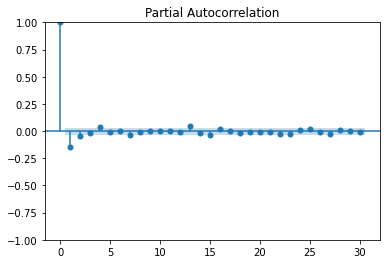

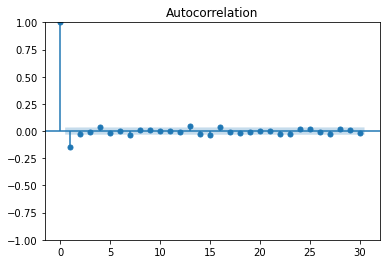

In [34]:
plt.figure(figsize=(10, 6))
plot_pacf(df_4556['diff24'].dropna(), lags=30);
plot_acf(df_4556['diff24'].dropna(), lags=30);

In [35]:
t = df_4556[df_4556['Time Interval'] < '2013-12-15 04:00:00']
train_data = t[t['Time Interval'] >= '2013-12-10 04:00:00']
train_data['Internet traffic activity'].fillna(train_data['Internet traffic activity'].mean(), inplace=True)

test_data = df_4556[df_4556['Time Interval'] >= '2013-12-16 04:00:00']
test_data['Internet traffic activity'].fillna(test_data['Internet traffic activity'].mean(), inplace=True)

model = SARIMAX(train_data['Internet traffic activity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 4))
mfit = model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [36]:
pred_4556 = mfit.predict(start=test_data.index[0], end=test_data.index[100])

C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Hp\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [37]:
pred_4556

1951165   -2202.103416
1951166   -2188.168950
1951167   -2206.980117
1951168   -2195.689432
1951169   -2202.108350
              ...     
1951261   -2202.221830
1951262   -2188.287364
1951263   -2207.098531
1951264   -2195.807846
1951265   -2202.226764
Name: predicted_mean, Length: 101, dtype: float64

<AxesSubplot:xlabel='Time Interval', ylabel='Internet traffic activity'>

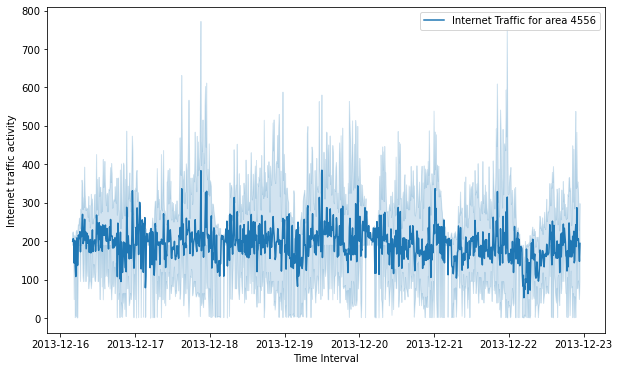

In [38]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=test_data, x='Time Interval', y='Internet traffic activity', label='Internet Traffic for area 4556')

<AxesSubplot:ylabel='predicted_mean'>

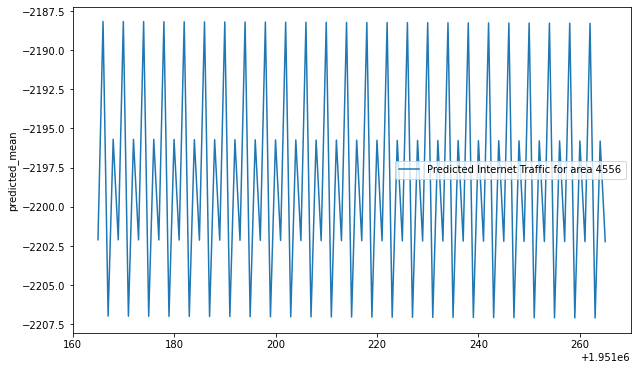

In [40]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pred_4556, label='Predicted Internet Traffic for area 4556')